In [44]:
import pandas as pd
import re
import string
import numpy as np

In [2]:
products = pd.DataFrame.from_csv('amazon_baby_subset_r2.csv')

In [3]:
important_words = pd.read_json('important_words_r2.json')

In [4]:
# data clean
products = products.fillna({'review': ''})
regex = re.compile('[%s]' % re.escape(string.punctuation))
def remove_punctuation(text):
    return regex.sub('', text)
products['clean_review'] = products['review'].apply(remove_punctuation)

In [5]:
# features extractor
for word in important_words[0]:
    products[word] = products['clean_review'].apply(lambda s: s.split().count(word))

In [6]:
# features counting
for word in important_words[0]:
    products['contains_{}'.format(word)] = products[word].apply(lambda c: 1 if c >= 1 else 0)

In [7]:
training_data_idx = pd.read_json('module-4-assignment-train-idx.json')
validation_data_idx = pd.read_json('module-4-assignment-validation-idx.json')

In [8]:
training_data = products.ix[training_data_idx[0]]
validation_data = products.ix[validation_data_idx[0]]

In [37]:
# convert dataframe to multi-dimensional array
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_parray = dataframe[label]
    label_array = label_parray.as_matrix()
    return (feature_matrix.astype(float), label_array.astype(float))

In [35]:
features = important_words[0].values.tolist()

In [38]:
feature_matrix_train, sentiment_train = get_numpy_data(training_data, features, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, features, 'sentiment') 

D:\Users\zeyang\Miniconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [39]:
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients)
    return 1 / (np.exp(-score) + 1)

In [129]:
def feature_derivative(errors, feature, coefficient, l2_penalty, feature_is_constant):
    derivative = np.dot(feature, errors)
    if feature_is_constant:
        return derivative
    return derivative - 2*l2_penalty*coefficient

In [130]:
# Quiz question: In the code above, was the intercept term regularized?
# Nope

In [131]:
def compute_log_likelihood(feature_matrix, sentiment, coefficients, l2_penalty):
    indicators = (sentiment == 1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicators - 1)*scores - np.log(1+np.exp(-scores))) - l2_penalty * np.sum(np.square(coefficients[1:]))
    return lp

In [132]:
# Quiz question: Does the term with L2 regularization increase or decrease ℓℓ(w)?
# Decrease

In [141]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    D = feature_matrix.shape[1]
    coefficients = np.array(initial_coefficients)
    for n in range(max_iter):
        predictions = predict_probability(feature_matrix, coefficients)
        indicators = (sentiment == 1)
        errors = indicators - predictions
        for i in range(D):
            feature = feature_matrix[:, i]
            derivative = feature_derivative(errors, feature, coefficients[i], l2_penalty, i==0)
            coefficients[i] += step_size*derivative
        if n%100 == 0:
            print('Running {}th iteration, current log-likehood is {}'.format(
                    n+1, compute_log_likelihood(feature_matrix, sentiment, coefficients, l2_penalty)))
    return coefficients

In [142]:
l2_penalty = [0, 4, 10, 1e2, 1e3, 1e5]

In [143]:
feature_matrix = feature_matrix_train
sentiment = sentiment_train
initial_coefficients = np.zeros(194)
step_size = 5e-6
max_iter = 501

In [215]:
coefficients = {}
for penalty in l2_penalty:
    print('Using l2_penalty {}'.format(penalty))
    coefficients['coefficients_{}_penalty'.format(penalty)] = logistic_regression_with_L2(
        feature_matrix, sentiment, initial_coefficients, step_size, penalty, max_iter)

Using l2_penalty 0
Running 1th iteration, current log-likehood is -29179.39138302689
Running 101th iteration, current log-likehood is -22794.90974920854
Running 201th iteration, current log-likehood is -21283.295273529307
Running 301th iteration, current log-likehood is -20570.97485472953
Running 401th iteration, current log-likehood is -20152.21466944124
Running 501th iteration, current log-likehood is -19876.623334098615
Using l2_penalty 4
Running 1th iteration, current log-likehood is -29179.395081753617
Running 101th iteration, current log-likehood is -22813.448445799357
Running 201th iteration, current log-likehood is -21321.141647938977
Running 301th iteration, current log-likehood is -20624.986344387962
Running 401th iteration, current log-likehood is -20219.920488449712
Running 501th iteration, current log-likehood is -19956.113417765006
Using l2_penalty 10
Running 1th iteration, current log-likehood is -29179.4006298437
Running 101th iteration, current log-likehood is -22841.0

In [157]:
coefficients.keys()

dict_keys(['coefficients_0_penalty', 'coefficients_100.0_penalty', 'coefficients_10_penalty', 'coefficients_100000.0_penalty', 'coefficients_4_penalty', 'coefficients_1000.0_penalty'])

In [160]:
zero_penalty_words = [(word, coeff) for word, coeff in zip(features, coefficients['coefficients_0_penalty'][1:])]

In [162]:
zero_penalty_words = sorted(zero_penalty_words, key=lambda x: x[1], reverse=True)

In [197]:
positive_words = [tup[0] for tup in zero_penalty_words[:5]]
negative_words = [tup[0] for tup in zero_penalty_words[-5:]]

In [222]:
negative_words

['returned', 'waste', 'return', 'money', 'disappointed']

In [198]:
positive_words

['love', 'loves', 'easy', 'perfect', 'great']

In [199]:
# Quiz Question. Which of the following is not listed in either positive_words or negative_words?

In [202]:
coefficients.keys()

dict_keys(['coefficients_0_penalty', 'coefficients_100.0_penalty', 'coefficients_10_penalty', 'coefficients_100000.0_penalty', 'coefficients_4_penalty', 'coefficients_1000.0_penalty'])

In [203]:
table = []
for idx, word in enumerate(features):
    coeff_list = [word]
    coeff_list.append(coefficients['coefficients_0_penalty'][idx])
    coeff_list.append(coefficients['coefficients_4_penalty'][idx])
    coeff_list.append(coefficients['coefficients_10_penalty'][idx])
    coeff_list.append(coefficients['coefficients_100.0_penalty'][idx])
    coeff_list.append(coefficients['coefficients_1000.0_penalty'][idx])
    coeff_list.append(coefficients['coefficients_100000.0_penalty'][idx])
    table.append(coeff_list)
headers = ['word', 'coefficients_0_penalty', 'coefficients_4_penalty', 'coefficients_10_penalty', 
           'coefficients_1e2_penalty', 'coefficients_1e3_penalty', 'coefficients_1e5_penalty']
table = pd.DataFrame(table, columns=headers)

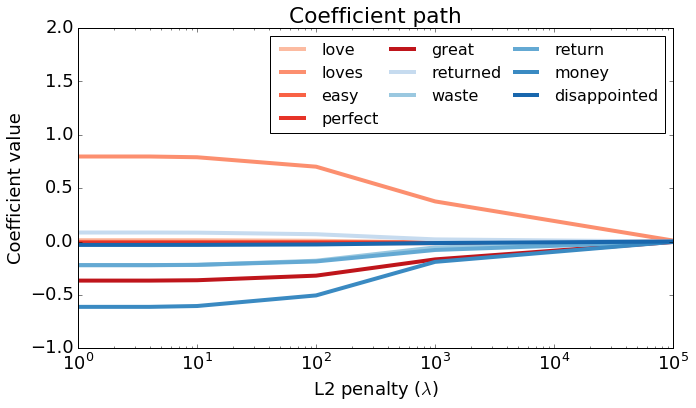

In [204]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

In [205]:
# Quiz Question: (True/False) All coefficients consistently get smaller in size as L2 penalty is increased.
# True

In [206]:
# Quiz Question: (True/False) Relative order of coefficients is preserved as L2 penalty is increased. 
# (If word 'cat' was more positive than word 'dog', then it remains to be so as L2 penalty is increased.)
# True

In [219]:
for key in coefficients:
    print(key)
    coeff = coefficients[key]
    predictions = (np.dot(feature_matrix_train, coeff) > 0).astype(int)
    np.place(predictions, predictions == 0, -1)
    print(np.sum(predictions==sentiment_train) / len(sentiment_train))

coefficients_0_penalty
0.785156157787
coefficients_100.0_penalty
0.783975826822
coefficients_10_penalty
0.784990911452
coefficients_100000.0_penalty
0.680366374731
coefficients_4_penalty
0.785108944548
coefficients_1000.0_penalty
0.775855149784


In [218]:
# Quiz question: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the training data?
# 0

In [220]:
for key in coefficients:
    print(key)
    coeff = coefficients[key]
    predictions = (np.dot(feature_matrix_valid, coeff) > 0).astype(int)
    np.place(predictions, predictions == 0, -1)
    print(np.sum(predictions==sentiment_valid) / len(sentiment_valid))

coefficients_0_penalty
0.78143964149
coefficients_100.0_penalty
0.781066193633
coefficients_10_penalty
0.781719727383
coefficients_100000.0_penalty
0.667818130893
coefficients_4_penalty
0.781533003454
coefficients_1000.0_penalty
0.771356549342


In [221]:
# Quiz question: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the validation data?
# 10

In [ ]:
# Quiz question: Does the highest accuracy on the training data imply that the model is the best one?
# Nope